# Table of contents
1. [Purpose](#purpose)
2. [Inputs](#inputs)
3. [Outputs](#outputs)
4. [Constraints](#constraints)
5. [Dependencies](#dependencies)
    * [5.1 Code Language](#codelanguage)
      * [5.1.1 package requirements](#packagerequirements)

6. [Code](#code)
    * [6.1 Management Summary](#code61)
    * [6.2 Protection Status Summary](#code62)
    * [6.3 Protection Level of Macrogroups by Ecoregion](#code63)
7. [Tests](#tests)
8. [Provenance](#provenance)
9. [Citations](#citations)
---

# Assessing the Conservation Status of Vegetation using the National Vegetation Classification (NVC)
<br/>

## Purpose <a name="purpose"></a>
The recent release of the USNVC Classification allows for the first time an assessment of the conservation status of the Groups and Macrogroups of the conterminous U.S.  While a previous assessment focused on detailed land cover based on NatureServe’s Ecological System Classification (Aycrigg et al. 2013), a cross-walk between that map legend and the NVC, as well as an update to the map itself provides for an assessment based on 2011 conditions and the mid-levels of the National Vegetation Classification Hierarchy. Specifically, by combining the GAP/LANDFIRE National Terrestrial Ecosystems data with USGS’s Gap Analysis Projects Protected Areas Database of the U.S. we were able to quantify the level of representation of each of the mapped existing vegetation types.

## Inputs <a name="inputs"></a>
The code in this notebook is intended to provide summaries for NVC vegetation types at multiple levels of the classification hierarchy. Summaries include information about the area occupied by each type, the percent of that area protected at GAP status 1 & 2, and 1, 2, & 3, and the area of each type being managed by ferderal and state agencies.
    
It utilizes a raster spatial data layer that was assembled by intersecting numerous spatial data layers including the PAD-US, boundary layers such as states, counties, LCCs, ecoregions, etc. At the time this workflow was developed, the raster dataset was available on a local server. Hence, all code references a local instance of this database. This code is only replicable given access to a local instance of the database.

This analysis relies on four major datasets within the analytic database including:
1. The detailed land cover dataset: GAP/LANDFIRE Existing Vegetation Type 2016 (https://www.landfire.gov/version_download.php)
2. The Protected Areas Database of the U.S. Version 2.1 (https://www.sciencebase.gov/catalog/item/5f186a2082cef313ed843257)
3. The U.S. National Vegetation Classification Version 2.0 (http://usnvc.org/explore-classification/)
4. A crosswalk between Ecological Systems and the USNVC Types (Embedded in the Attribute file for the National Terrestrials Ecosystems data https://www.sciencebase.gov/catalog/item/5810cd6fe4b0f497e7975237.

## Outputs <a name="outputs"></a>
Charts visualizing the extent of USNVC classes across various agencies and protection levels throughout CONUS under [four PAD-US protection status levels](https://www.usgs.gov/core-science-systems/science-analytics-and-synthesis/gap/science/pad-us-data-overview?qt-science_center_objects=0#qt-science_center_objects):  
<ul>
<ul>
    <li>Status 1: Biodiversity protection - natural disturbance permitted</li>
    <li>Status 2: Biodiversity protection - natural disturbance suppressed</li>
    <li>Status 3: Multiple use - extraction permitted</li>
    <li>Status 4: No known mandate for protection</li>
</ul>
</ul>

* [Management by USNVC Class:](#managechart)

Shows the area of each Class level vegetation type (Forest & Woodland; Shrub & Herbaceous Vegetation; Desert & Semi-Desert Vegetation...) managed by major federal and state management agencies
* [Protected Status of USNVC Groups:](#protectionchart)

A box plot summarizing the percent of the mapped area for each group that is protected at Status 1&2 and Status 1,2&3 within each USNVC Class
* [Protection Level of USNVC Macroroups by Ecoregion:](#macrogroupchart)

A horizontal bar plot summarizing the number of USNVC Macrogroups considered "protected" at Status 1&2 within Level II Ecoregions across four bins of percent protected:
* \< 1% Protected
* 1 - 17 % Protected
* 17 - 30 % Protected
* \> 30% Protected


## Constraints <a name="constraints"></a>
The Land Cover data attempts to map as accurately as possible the fine vegetative details of the nation’s vegetation. However, there are some limitations to the data that users should keep in mind. The data set uses a 30 meter pixel cell and in most areas a minimum mapping unit of 0.4 ha (1 acre). This means that small patches of vegetation can be missed in the modeling process.  The USNVC is a dynamic content standard, reflecting the state of the science at any point in time; therefore this analysis represents the conservation assessment based on the types that were named and described in the 2017 release of the classification.  

## Dependencies <a name="dependencies"></a>
These analyses are currently reliant on a local instance of a raster dataset that is a combination of PAD-US, Omernik Ecoregions and the National Vegetation Classification dataset.

Code execution and output visualization dependencies

* **Code Language** <a name="codelanguage"></a>  
This code is written in Python 3.x. Earlier versions may be compatible given slight alterations in syntax and package components.
  * **Python package requirements** <a name="packagerequirements"></a>  
  The required packages for proper code execution inlclude:
    - Pandas version 0.2x or above
    - GeoPanadas version 0.6x or above
    - numpy version 1.14.x or above
    - seaborn (statistical data visualization package) version 0.8 or above
    - matplotlib (figures library) version2.2.x or above
    - bokeh (interactive HTML charting package) version 0.12.x or above


## Tests <a name="tests"></a>
In developing this code the results were compared against a dataset generated through an independent spatial analysis.  

This analysis represents a CONUS wide assessment of the conservation status of natural vegetation.  It serves as an important baseline assessment of the extent, protection status, and management of those vegetation types. 

## Provenance <a name="provenance"></a>


## Code <a name="code"></a>

#### Import required Python packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib notebook

#### Accessing local spatial data layers and tables

In [2]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#            ++++ Directory Locations ++++
workDir = "D:/USGS Analyses/NVC-Analyses/"
dataDir = workDir+"data/"

# Read the local CSV data table into a Dataframe
dfAtt = pd.read_csv(dataDir+"attribute_table.csv")
# Read the raster attribute table of the spatial overlay layer into a Dataframe
gdfRas = gpd.read_file(dataDir+"nvcpader21.img.vat.dbf")


In [3]:
# Make all the column names in the CSV data table uppercase
dfAtt.columns = [x.upper() for x in dfAtt.columns]

In [4]:
# Pull out only the relevant columns from the data table
dfSub = dfAtt[['GAPST_CD',
'MANG_NAME',
'MANG_TYPE',
'CLASS',
'NVCGRP_LOOKUP2',
'GROUP',
'PADUS2_1DISS6ATT',
'ECOREGIONS_L4',
'NVC_NAME',
'NVC_CLASS',
'MACROGROUP',
'MACROGRO_1',
'US_L4CODE',
'US_L4NAME',
'US_L3CODE',
'US_L3NAME',
'NA_L2CODE',
'NA_L2NAME']]

# Make sure there are no duplicate rows
dfTable = dfSub.drop_duplicates()

# Drop the geometery column from the GeoDataframe of the raster attribute table
dfRAT = gdfRas.drop(['geometry'], axis=1)

# Now merge species range HUCs dataframe with HUC shapefile dataframe
dfMerge = pd.merge(left=dfRAT, right=dfTable, how='inner',
                   left_on=['NVCGRP_LOO','ECOREGIONS','PADUS2_1DI'],
                   right_on=['NVCGRP_LOOKUP2','ECOREGIONS_L4','PADUS2_1DISS6ATT'])


In [5]:
dfMerge

,VALUE,COUNT,PADUS2_1DI,ECOREGIONS,NVCGRP_LOO,GAPST_CD,MANG_NAME,MANG_TYPE,CLASS,NVCGRP_LOOKUP2,...,NVC_NAME,NVC_CLASS,MACROGROUP,MACROGRO_1,US_L4CODE,US_L4NAME,US_L3CODE,US_L3NAME,NA_L2CODE,NA_L2NAME
0,1,51,1614,315,385,3,County Land,Local Government,7 Agricultural & Developed Vegetation,385,...,Western Cool Temperate Developed Ruderal Everg...,7.0,M550,Tree Developed Vegetation,2a,Fraser Lowland,2,Puget Lowland,7.1,MARINE WEST COAST FOREST
1,2,33735,5000,315,85,4,Unknown,Unknown,1 Forest & Woodland,85,...,North Pacific Maritime Douglas-fir-Western Hem...,1.0,M024,Vancouverian Lowland & Montane Forest,2a,Fraser Lowland,2,Puget Lowland,7.1,MARINE WEST COAST FOREST
2,3,866,5000,315,0,4,Unknown,Unknown,NaN,0,...,NoData,NaN,NaN,NaN,2a,Fraser Lowland,2,Puget Lowland,7.1,MARINE WEST COAST FOREST
3,4,62,1614,315,384,3,County Land,Local Government,7 Agricultural & Developed Vegetation,384,...,Western Cool Temperate Developed Ruderal Decid...,7.0,M550,Tree Developed Vegetation,2a,Fraser Lowland,2,Puget Lowland,7.1,MARINE WEST COAST FOREST
4,5,120,1614,315,359,3,County Land,Local Government,Developed-Low Intensity,359,...,Developed-Low Intensity,8.0,8.A,Developed-Low Intensity,2a,Fraser Lowland,2,Puget Lowland,7.1,MARINE WEST COAST FOREST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864463,864464,5,2828,828,402,4,Department of Defense,Federal,7 Agricultural & Developed Vegetation,402,...,Eastern Warm Temperate Developed Ruderal Shrub...,7.0,M550,Tree Developed Vegetation,76d,Southern Coast and Islands,76,Southern Florida Coastal Plain,15.4,EVERGLADES
864464,864465,40,2417,828,360,3,State Park and Recreation,State,Developed-Medium Intensity,360,...,Developed-Medium Intensity,8.0,8.A,Developed-Medium Intensity,76d,Southern Coast and Islands,76,Southern Florida Coastal Plain,15.4,EVERGLADES
864465,864466,9,2417,828,361,3,State Park and Recreation,State,Developed-High Intensity,361,...,Developed-High Intensity,8.0,8.A,Developed-High Intensity,76d,Southern Coast and Islands,76,Southern Florida Coastal Plain,15.4,EVERGLADES
864466,864467,12,42,828,164,1,U.S. Fish and Wildlife Service,Federal,2 Shrub & Herb Vegetation,164,...,South Atlantic & Gulf Grass Coast & Dune,2.0,M057,Eastern North American Dune & Coastal Grasslan...,76d,Southern Coast and Islands,76,Southern Florida Coastal Plain,15.4,EVERGLADES


### ******* Management Summary ******* <a name="code61"></a>
---

#### Summarizing Areal Extent of NVC Classes Using Raster Cell Counts

In [6]:
## Summarize cell counts across Manager Name and Type, GAP Status, and NVC Class
sSum = dfMerge.groupby(['GAPST_CD','MANG_NAME','MANG_TYPE','CLASS'])['COUNT'].sum()
dfSum = pd.DataFrame(data=sSum)
dfClassSum = dfSum.reset_index()

# Rename the columns to match previous analyses dataframes
dfClassSum.rename(columns={'GAPST_CD':'PADStatus',
                           'MANG_NAME':'ManageName',
                           'MANG_TYPE':'ManageType',
                           'COUNT':'nCells'},inplace=True)

In [7]:
classnames = dfClassSum['CLASS'].unique().tolist()
classnames

['1 Forest & Woodland',
 '2 Shrub & Herb Vegetation',
 '6 Open Rock Vegetation',
 '7 Agricultural & Developed Vegetation',
 'Developed-High Intensity',
 'Developed-Low Intensity',
 'Developed-Medium Intensity',
 'Developed-Roads',
 'Open Water',
 '3 Desert & Semi-Desert',
 '4 Polar & High Montane Scrub Grassland & Barrens',
 'Nonvascular & Sparse Vascular Rock Vegetation',
 'Quarries-Strip Mines-Gravel Pits-Energy Development',
 'Recently Disturbed or Modified',
 '5 Aquatic Vegetation']

#### Pull out only the natural/non-anthropogenic NVC classes

In [8]:
# Pull out only the natural/non-anthropogenic NVC classes
print("Removing Anthropogenic Classes ....")
df2 = dfClassSum[(dfClassSum['CLASS'] == '1 Forest & Woodland') | 
         (dfClassSum['CLASS'] == '2 Shrub & Herb Vegetation') | 
         (dfClassSum['CLASS'] == '3 Desert & Semi-Desert') | 
         (dfClassSum['CLASS'] == '4 Polar & High Montane Scrub Grassland & Barrens') | 
         (dfClassSum['CLASS'] == '6 Open Rock Vegetation')]

Removing Anthropogenic Classes ....


In [9]:
# Add a column for NVC Class that removes the numbers from the names
df2['NVCClass'] = df2['CLASS'].str[2:]
# Drop the 'CLASS' column
df2 = df2.drop(['CLASS'], axis=1)
# Reorder the columns
df2 = df2[['PADStatus','ManageName','ManageType','NVCClass','nCells']]
df2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PADStatus,ManageName,ManageType,NVCClass,nCells
0,1,Army Corps of Engineers,Federal,Forest & Woodland,109180
1,1,Army Corps of Engineers,Federal,Shrub & Herb Vegetation,21421
2,1,Army Corps of Engineers,Federal,Open Rock Vegetation,18
9,1,Bureau of Land Management,Federal,Forest & Woodland,6118453
10,1,Bureau of Land Management,Federal,Shrub & Herb Vegetation,3330731
...,...,...,...,...,...
1694,4,Unknown,Unknown,Forest & Woodland,1388662088
1695,4,Unknown,Unknown,Shrub & Herb Vegetation,1064435102
1696,4,Unknown,Unknown,Desert & Semi-Desert,424091399
1697,4,Unknown,Unknown,Polar & High Montane Scrub Grassland & Barrens,228619


#### Add a new column for area in square kilometers -- (ignore the Python warnings)

In [10]:
# Add a new column for area in square kilometers
print("Calculating Area in km2 ....")
df2['km2'] = df2['nCells']*0.0009

Calculating Area in km2 ....


In [11]:
df2

,PADStatus,ManageName,ManageType,NVCClass,nCells,km2
0,1,Army Corps of Engineers,Federal,Forest & Woodland,109180,9.826200e+01
1,1,Army Corps of Engineers,Federal,Shrub & Herb Vegetation,21421,1.927890e+01
2,1,Army Corps of Engineers,Federal,Open Rock Vegetation,18,1.620000e-02
9,1,Bureau of Land Management,Federal,Forest & Woodland,6118453,5.506608e+03
10,1,Bureau of Land Management,Federal,Shrub & Herb Vegetation,3330731,2.997658e+03
...,...,...,...,...,...,...
1694,4,Unknown,Unknown,Forest & Woodland,1388662088,1.249796e+06
1695,4,Unknown,Unknown,Shrub & Herb Vegetation,1064435102,9.579916e+05
1696,4,Unknown,Unknown,Desert & Semi-Desert,424091399,3.816823e+05
1697,4,Unknown,Unknown,Polar & High Montane Scrub Grassland & Barrens,228619,2.057571e+02


#### Add a new column ManageCat that standarizes management types

In [12]:
mangnames = df2['ManageName'].unique().tolist()
mangnames

['Army Corps of Engineers',
 'Bureau of Land Management',
 'City Land',
 'County Land',
 'Forest Service',
 'Joint',
 'National Park Service',
 'Non-Governmental Organization',
 'Other or Unknown Federal Land',
 'Other or Unknown Local Government',
 'Other or Unknown State Land',
 'Private',
 'Regional Agency Land',
 'Regional Water Districts',
 'State Department of Conservation',
 'State Department of Land',
 'State Department of Natural Resources',
 'State Fish and Wildlife',
 'State Land Board',
 'State Park and Recreation',
 'Tennessee Valley Authority',
 'U.S. Fish and Wildlife Service',
 'Unknown',
 'Agricultural Research Service',
 'American Indian Areas',
 'Bureau of Reclamation',
 'Department of Defense',
 'Natural Resources Conservation Service',
 'Other',
 'National Oceanic and Atmospheric Administration',
 'Bonneville Power Administration',
 'Department of Energy']

In [13]:
# Add a new column ManageCat that standarizes management types
categories = {'Bureau of Land Management':'Bureau of Land Management',
'Forest Service':'Forest Service',
'National Park Service':'National Park Service',
'U.S. Fish & Wildlife Service':'U.S. Fish & Wildlife Service',
'U.S. Fish and Wildlife Service':'U.S. Fish & Wildlife Service',
'American Indian Lands':'Other',
'American Indian Areas':'Other',
'City Land':'Other',
'County Land':'Other',
'Joint':'Other',
'Non-Governmental Organization':'Other',
'Other':'Other',
'Other or Unknown Local Government':'Other',
'Private':'Other',
'Private-not in PADUS':'Other',
'Regional Agency Land':'Other',
'Regional Water Districts':'Other',
'Unknown':'Other',
'Agricultural Research Service':'Other Federal',
'Army Corps of Engineers':'Other Federal',
'Bonneville Power Administration':'Other Federal',
'Bureau of Indian Affairs':'Other Federal',
'Bureau of Reclamation':'Other Federal',
'Department of Defense':'Other Federal',
'Department of Energy':'Other Federal',
'National Oceanic and Atmospheric Administration':'Other Federal',
'Other or Unknown Federal Land':'Other Federal',
'Tennessee Valley Authority':'Other Federal',
'Natural Resources Conservation Service':'Other Federal',
'Other or Unknown State Land':'State',
'State Department of Conservation':'State',
'State Department of Land':'State',
'State Department of Natural Resources':'State',
'State Fish and Wildlife':'State',
'State Land Board':'State',
'State Park and Recreation':'State'}
print("Adding a Management Category Column ....")
df2['ManageCat'] = df2['ManageName'].map(categories)

Adding a Management Category Column ....


#### Remove the PAD status 4 records and shorten the "Polar" class text

In [14]:
# Make a new dataframe excluding PAD status 4 records
df3 = df2[(df2['PADStatus'] != 4)]
# Shorten the class text 'Polar & High Montane Scrub, Grassland & Barrens'
#  to 'Polar & High Montane' for better plotting
df3['NVCClass'] = np.where(df3['NVCClass']==
   'Polar & High Montane Scrub Grassland & Barrens',
   'Polar & High Montane', df3['NVCClass'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
df3['NVCClass'].unique().tolist()

['Forest & Woodland',
 'Shrub & Herb Vegetation',
 'Open Rock Vegetation',
 'Desert & Semi-Desert',
 'Polar & High Montane']

### Import the bokeh package for plotting and then start manipulating and organizing the data to prepare it as the data source for a bar chart figure

In [16]:
'''

    Plot stacked bar plots

'''
print("===== Begin Plotting =====")
# Using bokeh to plot with hierarchical labeling
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter, HoverTool

# Bokeh generates an HTML file for the figure
output_file(workDir + "ManagementSummary.html")

===== Begin Plotting =====


In [17]:
# -----------------------------------------------------------------------------
# Manipulate the dataframe to organize data to use as the plotting source

# Add a Status column based on PAD Status to summarize area protection
print("  adding protection status column ...")
df3['Status'] = np.where(df3['PADStatus']==3, 'Multiple Use', 'Protected')

# Drop PADStatus, ManageName, and nCellSum
df3 = df3.drop(['PADStatus','ManageName','nCells'], axis=1)
# There is no entry of 'Multiple Use' (i.e. status 3) for Polar & High Montane
#   - 'Other Federal' or - 'U.S. Fish & Wildlife Service' in the data making 
#   the records for status pairs uneven.
#  Add a row that is 0 for these criteria
dfa = pd.DataFrame([['Polar & High Montane',0.0,'Other Federal','Multiple Use'],
                   ['Polar & High Montane',0.0,'U.S. Fish & Wildlife Service','Multiple Use']],
                   columns=['NVCClass','km2','ManageCat','Status'])
df3 = df3.append(dfa, ignore_index=True)

# Summarize protection area by category, class, and status
print("  summarizing protection area by category, class and status ...")
dfSumKm = df3.groupby(by=['ManageCat','NVCClass','Status'])['km2'].sum().reset_index()
# Make a column of tupled category and class to index off
dfSumKm['CatCls'] = list(zip(dfSumKm['ManageCat'], dfSumKm['NVCClass']))
# Drop ManageCat and NVCClass columns
dfSumKm = dfSumKm.drop(['ManageCat','NVCClass'], axis=1)

# Pivot on Status and make the tupled category and class column the index
print("  pivoting on status column ...")
df4 = dfSumKm.pivot(index='CatCls', columns='Status', values='km2')
# Reorder columns
df4 = df4[['Protected', 'Multiple Use']]

# Reorder the rows using a preset order dictionary
print("  reordering rows ...")
sort = {('Bureau of Land Management', 'Forest & Woodland'):1,
('Bureau of Land Management', 'Shrub & Herb Vegetation'):2,
('Bureau of Land Management', 'Desert & Semi-Desert'):3,
('Bureau of Land Management', 'Polar & High Montane'):4,
('Bureau of Land Management', 'Open Rock Vegetation'):5,
('Forest Service', 'Forest & Woodland'):6,
('Forest Service', 'Shrub & Herb Vegetation'):7,
('Forest Service', 'Desert & Semi-Desert'):8,
('Forest Service', 'Polar & High Montane'):9,
('Forest Service', 'Open Rock Vegetation'):10,
('National Park Service', 'Forest & Woodland'):11,
('National Park Service', 'Shrub & Herb Vegetation'):12,
('National Park Service', 'Desert & Semi-Desert'):13,
('National Park Service', 'Polar & High Montane'):14,
('National Park Service', 'Open Rock Vegetation'):15,
('U.S. Fish & Wildlife Service', 'Forest & Woodland'):16,
('U.S. Fish & Wildlife Service', 'Shrub & Herb Vegetation'):17,
('U.S. Fish & Wildlife Service', 'Desert & Semi-Desert'):18,
('U.S. Fish & Wildlife Service', 'Polar & High Montane'):19,
('U.S. Fish & Wildlife Service', 'Open Rock Vegetation'):20,
('Other Federal', 'Forest & Woodland'):21,
('Other Federal', 'Shrub & Herb Vegetation'):22,
('Other Federal', 'Desert & Semi-Desert'):23,
('Other Federal', 'Polar & High Montane'):24,
('Other Federal', 'Open Rock Vegetation'):25,
('State', 'Forest & Woodland'):26,
('State', 'Shrub & Herb Vegetation'):27,
('State', 'Desert & Semi-Desert'):28,
('State', 'Polar & High Montane'):29,
('State', 'Open Rock Vegetation'):30,
('Other', 'Forest & Woodland'):31,
('Other', 'Shrub & Herb Vegetation'):32,
('Other', 'Desert & Semi-Desert'):33,
('Other', 'Polar & High Montane'):34,
('Other', 'Open Rock Vegetation'):35}

# Make a new dataframe by resetting the df4 index
df5 = df4.reset_index()
# Add the sortid column for sorting then sort
df5['sortid'] = df5['CatCls'].map(sort)
df5sort = df5.sort_values(by='sortid')
# Drop the sortid column then change the index back to CatCls
dfSource = df5sort.drop(['sortid'],axis=1)
dfSource = dfSource.set_index(keys=['CatCls'])
# Add a total km2 column
dfSource['Total Area'] = dfSource['Protected'] + dfSource['Multiple Use']

  adding protection status column ...
  summarizing protection area by category, class and status ...
  pivoting on status column ...
  reordering rows ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Management by NVC Class <a name="managechart"></a>
#### Configure the data and create an HTML file of the stacked bar chart

Note that the HTML file of the bar chart figure is interactive. There is a toolbar on the right side of the chart area.

In [18]:
# +++++++++++++++++++++++++++++++++++++++ Plotting +++++++++++++++++++++++++++++++++++++++++++++++++++
print("+++++ Sending Plot to HTML File +++++")
colors = ['#286000','#a6e883'] # Protected | Multiple Use
p = figure(title="Management by USNVC Class", plot_width=1100, x_range=FactorRange(*dfSource.index))

tt = HoverTool(
tooltips=[
    ("Protected", "@Protected{0,0}"),
    ("Multiple Use", "@{Multiple Use}{0,0}"),
    ("Total", "@{Total Area}{0,0}")
    ]
)
#lab = ["Protected","Multiple Use"]
legendList=[value(x) for x in dfSource.columns[0:2]]
p.vbar_stack(dfSource.columns[0:2], x='CatCls', width=0.8, color=colors, 
             source=dfSource, legend_label=["Protected","Multiple Use"]) 

p.add_tools(tt)
p.title.align = "center"
p.title.text_font_size = '12pt'
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = 1.55
p.xaxis.axis_label_text_font_style = "normal"
p.y_range.start = 0
p.y_range.end = 150000
p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = "Square Kilometers"
p.yaxis.axis_label_text_font_style = "normal"

show(p)

+++++ Sending Plot to HTML File +++++


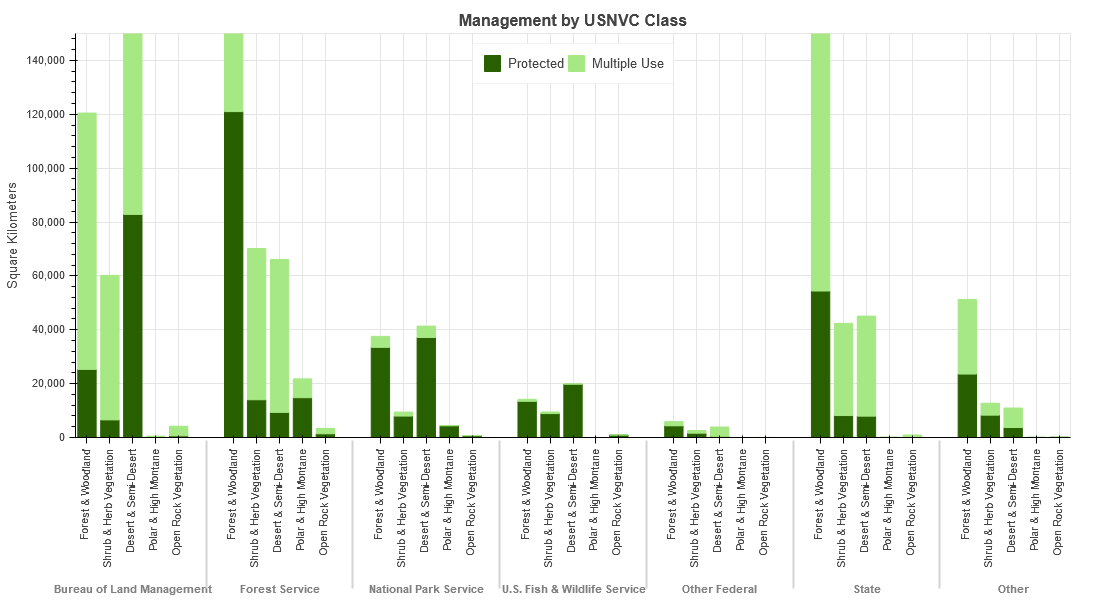

In [22]:
# The following will render the HTML file in the notebook using a local file source
from IPython.core.display import display, HTML, Image
#display(HTML(filename=workDir + "/ManagementSummary.html"))
# To display this on GitHub, render a screenshot image
repoDir = "D:/USGS Analyses/NVC-Analyses"
display(Image(filename=repoDir + '/ManagementSummaryImage.png', embed=True))

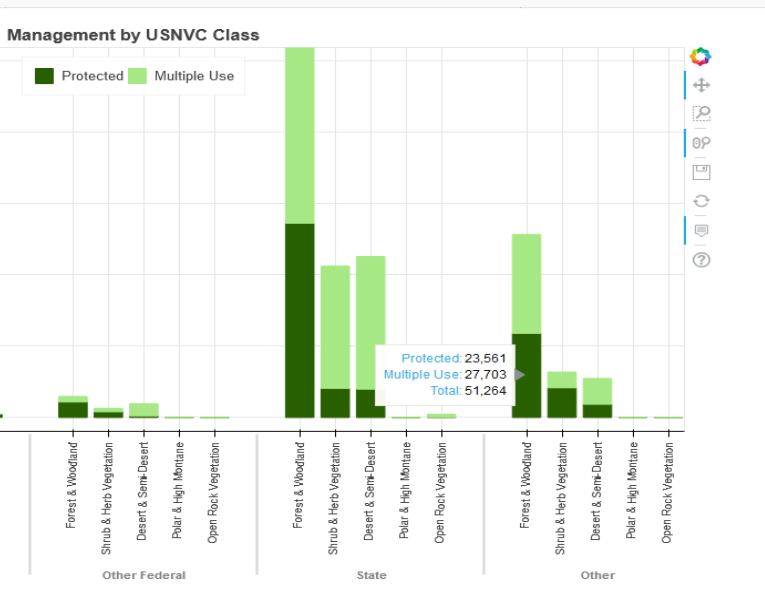

In [15]:
display(Image(filename=workDir + '/BokehPlotZoom.png', embed=True))

### ******* Protection Status Summary ******* <a name="code62"></a>
---

#### Summarize NVC Groups, Classes, and PAD Status using the Merged Dataframe

In [19]:
## Summarize cell counts from the spatial raster grouping on NVC Groups by NVC Class
sSum = dfMerge.groupby(['GAPST_CD','GROUP','CLASS'])['COUNT'].sum()
dfSum = pd.DataFrame(data=sSum)
dfGroupSum = dfSum.reset_index()

In [20]:
dfGroupSum

,GAPST_CD,GROUP,CLASS,COUNT
0,1,Eastern Boreal Balsam Fir-Black Spruce Interm...,1 Forest & Woodland,655
1,1,Appalachian & Allegheny Northern Hardwood-Coni...,1 Forest & Woodland,846084
2,1,Appalachian & Interior Mesic Forest,1 Forest & Woodland,2048068
3,1,Appalachian & Interior Riverscour Barrens & Pr...,2 Shrub & Herb Vegetation,2686
4,1,Appalachian Mafic Glade,2 Shrub & Herb Vegetation,5539
...,...,...,...,...
1226,4,Western Montane-Subalpine Riparian & Seep Shru...,2 Shrub & Herb Vegetation,1551613
1227,4,Western North American Montane Sclerophyll Scrub,2 Shrub & Herb Vegetation,3198025
1228,4,Western North American Ruderal Wet Shrubland M...,2 Shrub & Herb Vegetation,3334590
1229,4,Wet-Mesic Longleaf Pine Woodland,1 Forest & Woodland,7956067


In [21]:
dfGroupSum['CLASS'].unique().tolist()

['1 Forest & Woodland',
 '2 Shrub & Herb Vegetation',
 '3 Desert & Semi-Desert',
 'Nonvascular & Sparse Vascular Rock Vegetation',
 '6 Open Rock Vegetation',
 'Developed-High Intensity',
 'Developed-Low Intensity',
 'Developed-Medium Intensity',
 'Developed-Roads',
 '4 Polar & High Montane Scrub Grassland & Barrens',
 '5 Aquatic Vegetation',
 '7 Agricultural & Developed Vegetation',
 'Open Water',
 'Quarries-Strip Mines-Gravel Pits-Energy Development',
 'Recently Disturbed or Modified']

In [22]:
dfOneGroup = dfGroupSum[dfGroupSum['GROUP'] == 'Western Madrean Chaparral']
dfOneGroup

,GAPST_CD,GROUP,CLASS,COUNT
297,1,Western Madrean Chaparral,2 Shrub & Herb Vegetation,1555567
606,2,Western Madrean Chaparral,2 Shrub & Herb Vegetation,1007729
915,3,Western Madrean Chaparral,2 Shrub & Herb Vegetation,5506769
1225,4,Western Madrean Chaparral,2 Shrub & Herb Vegetation,5837957


#### Change some of the NVC Class names to remove the numeric part of the name

In [23]:
## Edit the NVC Class names to remove the leading numeric character
dfGroupSum.replace({'CLASS': r'\d\s'}, {'CLASS': ''}, regex=True, inplace=True)

In [24]:
dfGroupSum['CLASS'].unique().tolist()

['Forest & Woodland',
 'Shrub & Herb Vegetation',
 'Desert & Semi-Desert',
 'Nonvascular & Sparse Vascular Rock Vegetation',
 'Open Rock Vegetation',
 'Developed-High Intensity',
 'Developed-Low Intensity',
 'Developed-Medium Intensity',
 'Developed-Roads',
 'Polar & High Montane Scrub Grassland & Barrens',
 'Aquatic Vegetation',
 'Agricultural & Developed Vegetation',
 'Open Water',
 'Quarries-Strip Mines-Gravel Pits-Energy Development',
 'Recently Disturbed or Modified']

In [25]:
dfPivot = dfGroupSum.pivot(index=['CLASS','GROUP'], columns=['GAPST_CD'], values='COUNT')

In [26]:
dfPivot

GAPST_CD                                                                                        1  \
CLASS                               GROUP                                                           
Agricultural & Developed Vegetation Eastern North American Temperate Forest Plantation   423652.0   
                                    Temperate Shrub & Herb Developed Vegetation          109914.0   
                                    Temperate Tree Developed Vegetation                  347323.0   
                                    Tropical & Temperate Aquaculture                        260.0   
                                    Tropical & Temperate Bush Fruit & Berry                 152.0   
...                                                                                           ...   
Shrub & Herb Vegetation             Western Great Plains Saline Depression Wetland         3201.0   
                                    Western Madrean Chaparral                           1555567.0   
                                    Western Montane-Subalpine Riparian & Seep Shrub...   450307.0   
                                    Western North American Montane Sclerophyll Scrub    3364438.0   
                                    Western North American Ruderal Wet Shrubland Me...    24407.0   

GAPST_CD                                                                                        2  \
CLASS                               GROUP                                                           
Agricultural & Developed Vegetation Eastern North American Temperate Forest Plantation  7767051.0   
                                    Temperate Shrub & Herb Developed Vegetation         1665477.0   
                                    Temperate Tree Developed Vegetation                 3966785.0   
                                    Tropical & Temperate Aquaculture                       7482.0   
                                    Tropical & Temperate Bush Fruit & Berry               12744.0   
...                                                                                           ...   
Shrub & Herb Vegetation             Western Great Plains Saline Depression Wetland        13565.0   
                                    Western Madrean Chaparral                           1007729.0   
                                    Western Montane-Subalpine Riparian & Seep Shrub...   201556.0   
                                    Western North American Montane Sclerophyll Scrub     498783.0   
                                    Western North American Ruderal Wet Shrubland Me...   921813.0   

GAPST_CD                                                                                         3  \
CLASS                               GROUP                                                            
Agricultural & Developed Vegetation Eastern North American Temperate Forest Plantation  10460558.0   
                                    Temperate Shrub & Herb Developed Vegetation          2559219.0   
                                    Temperate Tree Developed Vegetation                  6273107.0   
                                    Tropical & Temperate Aquaculture                       32301.0   
                                    Tropical & Temperate Bush Fruit & Berry                12272.0   
...                                                                                            ...   
Shrub & Herb Vegetation             Western Great Plains Saline Depression Wetland          7990.0   
                                    Western Madrean Chaparral                            5506769.0   
                                    Western Montane-Subalpine Riparian & Seep Shrub...   1067386.0   
                                    Western North American Montane Sclerophyll Scrub     5588247.0   
                                    Western North American Ruderal Wet Shrubland Me...    381313.0   

GAPST_CD                                     

In [27]:
df = dfPivot.reset_index(level=(0,1))

In [28]:
df

GAPST_CD,CLASS,GROUP,1,2,3,4
0,Agricultural & Developed Vegetation,Eastern North American Temperate Forest Planta...,423652.0,7767051.0,10460558.0,194730652.0
1,Agricultural & Developed Vegetation,Temperate Shrub & Herb Developed Vegetation,109914.0,1665477.0,2559219.0,103974651.0
2,Agricultural & Developed Vegetation,Temperate Tree Developed Vegetation,347323.0,3966785.0,6273107.0,248261145.0
3,Agricultural & Developed Vegetation,Tropical & Temperate Aquaculture,260.0,7482.0,32301.0,936523.0
4,Agricultural & Developed Vegetation,Tropical & Temperate Bush Fruit & Berry,152.0,12744.0,12272.0,1004736.0
...,...,...,...,...,...,...
305,Shrub & Herb Vegetation,Western Great Plains Saline Depression Wetland,3201.0,13565.0,7990.0,149784.0
306,Shrub & Herb Vegetation,Western Madrean Chaparral,1555567.0,1007729.0,5506769.0,5837957.0
307,Shrub & Herb Vegetation,Western Montane-Subalpine Riparian & Seep Shru...,450307.0,201556.0,1067386.0,1551613.0
308,Shrub & Herb Vegetation,Western North American Montane Sclerophyll Scrub,3364438.0,498783.0,5588247.0,3198025.0


In [29]:
# Fill all the empty values with 0 and rename columns
df['PAD1'] = df[1].fillna(0)
df['PAD2'] = df[2].fillna(0)
df['PAD3'] = df[3].fillna(0)
df['PAD4'] = df[4].fillna(0)


# Drop the original PAD status columns
df = df.drop(1, axis=1)
df = df.drop(2, axis=1)
df = df.drop(3, axis=1)
df = df.drop(4, axis=1)

# Add a Group total cell count column
df['nGroupTotalCells'] = df['PAD1'] + df['PAD2'] + df['PAD3'] + df['PAD4']

In [30]:
df

GAPST_CD,CLASS,GROUP,PAD1,PAD2,PAD3,PAD4,nGroupTotalCells
0,Agricultural & Developed Vegetation,Eastern North American Temperate Forest Planta...,423652.0,7767051.0,10460558.0,194730652.0,213381913.0
1,Agricultural & Developed Vegetation,Temperate Shrub & Herb Developed Vegetation,109914.0,1665477.0,2559219.0,103974651.0,108309261.0
2,Agricultural & Developed Vegetation,Temperate Tree Developed Vegetation,347323.0,3966785.0,6273107.0,248261145.0,258848360.0
3,Agricultural & Developed Vegetation,Tropical & Temperate Aquaculture,260.0,7482.0,32301.0,936523.0,976566.0
4,Agricultural & Developed Vegetation,Tropical & Temperate Bush Fruit & Berry,152.0,12744.0,12272.0,1004736.0,1029904.0
...,...,...,...,...,...,...,...
305,Shrub & Herb Vegetation,Western Great Plains Saline Depression Wetland,3201.0,13565.0,7990.0,149784.0,174540.0
306,Shrub & Herb Vegetation,Western Madrean Chaparral,1555567.0,1007729.0,5506769.0,5837957.0,13908022.0
307,Shrub & Herb Vegetation,Western Montane-Subalpine Riparian & Seep Shru...,450307.0,201556.0,1067386.0,1551613.0,3270862.0
308,Shrub & Herb Vegetation,Western North American Montane Sclerophyll Scrub,3364438.0,498783.0,5588247.0,3198025.0,12649493.0


In [31]:
# Calculate area in km2
df['PAD1 km2'] = df['PAD1'] * 0.0009
df['PAD2 km2'] = df['PAD2'] * 0.0009
df['PAD3 km2'] = df['PAD3'] * 0.0009
df['PAD4 km2'] = df['PAD4'] * 0.0009


# Calculate percentages
df['% Protected 1 & 2'] = ((df['PAD1'] + df['PAD2'] ) / df['nGroupTotalCells']) * 100
df['% Protected 1, 2 & 3'] = ((df['PAD1'] + df['PAD2'] + df['PAD3']) / df['nGroupTotalCells']) * 100


In [32]:
df

GAPST_CD,CLASS,GROUP,PAD1,PAD2,PAD3,PAD4,nGroupTotalCells,PAD1 km2,PAD2 km2,PAD3 km2,PAD4 km2,% Protected 1 & 2,"% Protected 1, 2 & 3"
0,Agricultural & Developed Vegetation,Eastern North American Temperate Forest Planta...,423652.0,7767051.0,10460558.0,194730652.0,213381913.0,381.2868,6990.3459,9414.5022,175257.5868,3.838518,8.740788
1,Agricultural & Developed Vegetation,Temperate Shrub & Herb Developed Vegetation,109914.0,1665477.0,2559219.0,103974651.0,108309261.0,98.9226,1498.9293,2303.2971,93577.1859,1.639187,4.002068
2,Agricultural & Developed Vegetation,Temperate Tree Developed Vegetation,347323.0,3966785.0,6273107.0,248261145.0,258848360.0,312.5907,3570.1065,5645.7963,223435.0305,1.666655,4.090122
3,Agricultural & Developed Vegetation,Tropical & Temperate Aquaculture,260.0,7482.0,32301.0,936523.0,976566.0,0.2340,6.7338,29.0709,842.8707,0.792778,4.100389
4,Agricultural & Developed Vegetation,Tropical & Temperate Bush Fruit & Berry,152.0,12744.0,12272.0,1004736.0,1029904.0,0.1368,11.4696,11.0448,904.2624,1.252156,2.443723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Shrub & Herb Vegetation,Western Great Plains Saline Depression Wetland,3201.0,13565.0,7990.0,149784.0,174540.0,2.8809,12.2085,7.1910,134.8056,9.605821,14.183568
306,Shrub & Herb Vegetation,Western Madrean Chaparral,1555567.0,1007729.0,5506769.0,5837957.0,13908022.0,1400.0103,906.9561,4956.0921,5254.1613,18.430342,58.024534
307,Shrub & Herb Vegetation,Western Montane-Subalpine Riparian & Seep Shru...,450307.0,201556.0,1067386.0,1551613.0,3270862.0,405.2763,181.4004,960.6474,1396.4517,19.929395,52.562566
308,Shrub & Herb Vegetation,Western North American Montane Sclerophyll Scrub,3364438.0,498783.0,5588247.0,3198025.0,12649493.0,3027.9942,448.9047,5029.4223,2878.2225,30.540520,74.718157


Now we need to do some manipulation of the % protected data to calculate how many NVC groups fall into the protected bins:
* < 1%
* 1-17%
* 17-50%
* \> 50%

Then, these groups need to be summarized by NVC class (there are 12) EXCLUDING the anthropogenic and non-vegetaion classes:
* Recently Disturbed or Modified
* Open Water
* Nonvascular & Sparse Vascular Rock Vegetation
* Agricultural & Developed Vegetation
* Developed & Other Human Use
* Introduced & Semi Natural Vegetation
* Aquatic Vegetation

That leaves the following NVC classes remaining to summarize protection status percentages:
* Desert & Semi-Desert
* Forest & Woodland
* Open Rock Vegetation
* Polar & High Montane Scrub, Grassland & Barrens
* Shrub & Herb Vegetation

In [33]:
lt1 = len(df[df['% Protected 1 & 2'] < 1])
lt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17)])
lt50 = len(df[(df['% Protected 1 & 2'] > 17) & (df['% Protected 1 & 2'] < 50)])
gt50 = len(df[df['% Protected 1 & 2'] > 50])

print('Number of NVC groups with less than 1 % protection = ', lt1)
print('Number of NVC groups with more than 1 % and less than 17% protection = ', lt17)
print('Number of NVC groups with more than 17 % and less than 50% protection = ', lt50)
print('Number of NVC groups with more than 50 % protection = ', gt50)

Number of NVC groups with less than 1 % protection =  16
Number of NVC groups with more than 1 % and less than 17% protection =  182
Number of NVC groups with more than 17 % and less than 50% protection =  90
Number of NVC groups with more than 50 % protection =  22


In [34]:
DsDlt1 = len(df[(df['% Protected 1 & 2'] < 1) & (df['CLASS'] == 'Desert & Semi-Desert')])
print('Number of groups in Desert & Semi-desert class with less than 1% protection:', DsDlt1)

FWlt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17) & (df['CLASS'] == 'Forest & Woodland')])
print('Number of groups in Forest and Woodland class with less than 17% protection:', FWlt17)

Number of groups in Desert & Semi-desert class with less than 1% protection: 2
Number of groups in Forest and Woodland class with less than 17% protection: 91


Start manipulating the data to:
* Exclude the anthropogenic and non-vegetation classes
* Limit the columns to only the percent protection status amounts for each class
* Pivot the data to assist in plotting

In [35]:
df2 = df[['CLASS','GROUP','% Protected 1 & 2','% Protected 1, 2 & 3']]
# Pull out only the natural/non-anthropogenic NVC classes
df3 = df2[(df2['CLASS'] == 'Forest & Woodland') | 
				(df2['CLASS'] == 'Shrub & Herb Vegetation') | 
				(df2['CLASS'] == 'Desert & Semi-Desert') | 
				(df2['CLASS'] == 'Polar & High Montane Scrub Grassland & Barrens') | 
				(df2['CLASS'] == 'Open Rock Vegetation')]

# Re-orient the dataframe to generate boxplots for each NVC class
df3_melt = df3.melt(id_vars = 'CLASS',
                  value_vars = ['% Protected 1 & 2',
                                '% Protected 1, 2 & 3'],
                  var_name = 'Percent Protected',
                  value_name = 'Percent of Mapped Area')


In [36]:
df3_melt.head(5)

,CLASS,Percent Protected,Percent of Mapped Area
0,Desert & Semi-Desert,% Protected 1 & 2,16.714477
1,Desert & Semi-Desert,% Protected 1 & 2,5.985958
2,Desert & Semi-Desert,% Protected 1 & 2,6.207245
3,Desert & Semi-Desert,% Protected 1 & 2,5.226946
4,Desert & Semi-Desert,% Protected 1 & 2,3.710048


In [37]:
df3_melt.tail(5)

,CLASS,Percent Protected,Percent of Mapped Area
573,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",14.183568
574,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",58.024534
575,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",52.562566
576,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",74.718157
577,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",28.474860


Finally, plot the data using a boxplot (using the Seaborn statistical visualization package) where classes are on the x-axis and protection status levels (1 & 2 and 1, 2, & 3) are paired together in the plot.

There are numerous formatting options available in matplotlib, a few are utilized here.

## Protection of NVC Groups across NVC Classes <a name="protectionchart"></a>

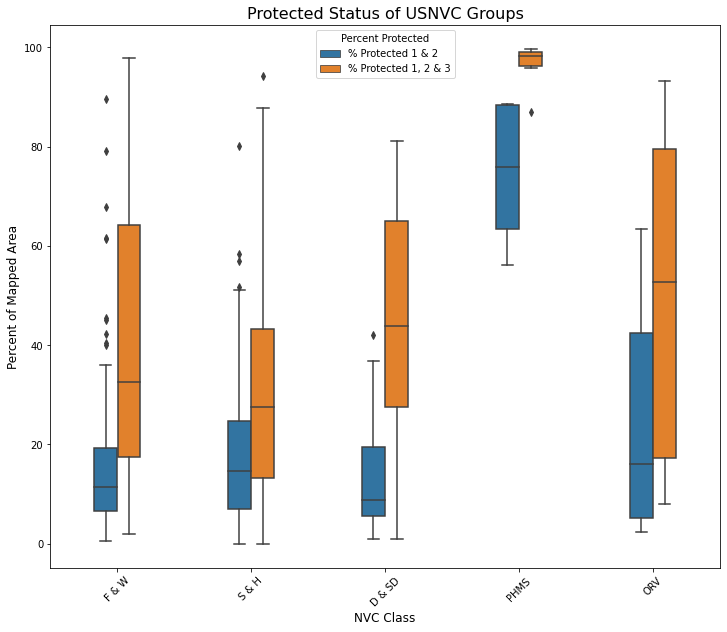

In [38]:
fig, ax = plt.subplots(figsize=(12,10))
plt.xticks(rotation=45)
a = sns.boxplot(data = df3_melt,
                hue = 'Percent Protected',
                x = 'CLASS',
                y = 'Percent of Mapped Area',
                order = ['Forest & Woodland',
                         'Shrub & Herb Vegetation',
                         'Desert & Semi-Desert',
                         'Polar & High Montane Scrub Grassland & Barrens',
                         'Open Rock Vegetation'],
                width=0.35,
                ax=ax)
a.set_xlabel('NVC Class', fontsize=12)
a.set_ylabel('Percent of Mapped Area', fontsize=12)
labels = ['F & W','S & H','D & SD','PHMS','ORV']
a.set_xticklabels(labels)
a.set_title('Protected Status of USNVC Groups', fontsize=16)
plt.legend(loc='upper center',title='Percent Protected')
plt.show()


In [39]:
### Export the pivoted protection dataframe to a CSV
df.to_csv(dataDir+"ProtectionTable-2020.csv", index=False)

### ******* Protection Level of Macrogroups by Ecoregion ******* <a name="code63"></a>
---

##### Begin by manipulating the dataframe of the raster table and the CSV table

In [40]:
# Rename the Upper Gila Mountains ecoregion with the question mark in it
dfMerge['NA_L2NAME'] = np.where(dfMerge['NA_L2NAME']==
   'UPPER GILA MOUNTAINS (?)',
   'UPPER GILA MOUNTAINS', dfMerge['NA_L2NAME'])

In [41]:
classnames = dfMerge['CLASS'].unique().tolist()
classnames

['7 Agricultural & Developed Vegetation',
 '1 Forest & Woodland',
 nan,
 'Developed-Low Intensity',
 'Developed-Roads',
 'Developed-Medium Intensity',
 'Developed-High Intensity',
 '2 Shrub & Herb Vegetation',
 '6 Open Rock Vegetation',
 'Open Water',
 'Recently Disturbed or Modified',
 'Quarries-Strip Mines-Gravel Pits-Energy Development',
 '3 Desert & Semi-Desert',
 '4 Polar & High Montane Scrub Grassland & Barrens',
 'Nonvascular & Sparse Vascular Rock Vegetation',
 '5 Aquatic Vegetation']

In [42]:
# Pull out only the natural/non-anthropogenic NVC classes
print("Removing Anthropogenic Classes ....")
dfNatural = dfMerge[(dfMerge['CLASS'] == '1 Forest & Woodland') | 
         (dfMerge['CLASS'] == '2 Shrub & Herb Vegetation') | 
         (dfMerge['CLASS'] == '3 Desert & Semi-Desert') | 
         (dfMerge['CLASS'] == '4 Polar & High Montane Scrub Grassland & Barrens') | 
         (dfMerge['CLASS'] == '6 Open Rock Vegetation')]

Removing Anthropogenic Classes ....


In [43]:
## Summarize cell counts across GAP Status, Level 2 Ecoregion, and NVC Macrogroup
sSum = dfNatural.groupby(['GAPST_CD','NA_L2NAME','MACROGRO_1'])['COUNT'].sum()
dfSum = pd.DataFrame(data=sSum)
dfEcoGroupSum = dfSum.reset_index()

# Rename the columns to match previous analyses dataframes
dfEcoGroupSum.rename(columns={'GAPST_CD':'PADStatus',
                           'NA_L2NAME':'Level2Name',
                           'MACROGRO_1':'MacrogroupName',
                           'COUNT':'nCells'},inplace=True)
dfEcoGroupSum

,PADStatus,Level2Name,MacrogroupName,nCells
0,1,ATLANTIC HIGHLANDS,Appalachian & Northeastern Oak-Hardwood & Pine...,27736
1,1,ATLANTIC HIGHLANDS,Appalachian Interior & Northeastern Mesic Forest,450582
2,1,ATLANTIC HIGHLANDS,Appalachian Rocky Felsic & Mafic Scrub & Grass...,8543
3,1,ATLANTIC HIGHLANDS,Central & Appalachian Floodplain Forest,3582
4,1,ATLANTIC HIGHLANDS,Central & Appalachian Swamp Forest,24
...,...,...,...,...
2506,4,WESTERN SIERRA MADRE PIEDMONT,Warm & Cool Desert Alkali-Saline Wetland,325273
2507,4,WESTERN SIERRA MADRE PIEDMONT,Warm Desert Lowland Freshwater Shrubland meado...,79787
2508,4,WESTERN SIERRA MADRE PIEDMONT,Warm Interior Chaparral,1017468
2509,4,WESTERN SIERRA MADRE PIEDMONT,Western North American Montane-Subalpine Wet S...,381


In [44]:
# Get a list of unique Level II Ecoregions
level2ecos = dfEcoGroupSum['Level2Name'].unique().tolist()
level2ecos

['ATLANTIC HIGHLANDS',
 'CENTRAL USA PLAINS',
 'COLD DESERTS',
 'EVERGLADES',
 'MARINE WEST COAST FOREST',
 'MEDITERRANEAN CALIFORNIA',
 'MISSISSIPPI ALLUVIAL AND SOUTHEAST USA COASTAL PLAINS',
 'MIXED WOOD PLAINS',
 'MIXED WOOD SHIELD',
 'OZARK/OUACHITA-APPALACHIAN FORESTS',
 'SOUTH CENTRAL SEMI-ARID PRAIRIES',
 'SOUTHEASTERN USA PLAINS',
 'TEMPERATE PRAIRIES',
 'TEXAS-LOUISIANA COASTAL PLAIN',
 'UPPER GILA MOUNTAINS',
 'WARM DESERTS',
 'WEST-CENTRAL SEMI-ARID PRAIRIES',
 'WESTERN CORDILLERA',
 'WESTERN SIERRA MADRE PIEDMONT',
 'TAMAULIPAS-TEXAS SEMIARID PLAIN']

In [45]:
# Pivot the Ecoregion-Macrogrup dataframe on PAD Status
dfPivot = dfEcoGroupSum.pivot(index=['Level2Name','MacrogroupName'], columns=['PADStatus'], values='nCells')
df = dfPivot.reset_index(level=(0,1))
df

PADStatus,Level2Name,MacrogroupName,1,2,3,4
0,ATLANTIC HIGHLANDS,Appalachian & Northeastern Oak-Hardwood & Pine...,27736.0,109934.0,297588.0,1535222.0
1,ATLANTIC HIGHLANDS,Appalachian Interior & Northeastern Mesic Forest,450582.0,398833.0,6058310.0,9499064.0
2,ATLANTIC HIGHLANDS,Appalachian Rocky Felsic & Mafic Scrub & Grass...,8543.0,25472.0,24319.0,195725.0
3,ATLANTIC HIGHLANDS,Atlantic & Gulf Coastal Freshwater & Oligohali...,NaN,765.0,11.0,1100.0
4,ATLANTIC HIGHLANDS,Atlantic & Gulf Coastal Plain Wet Prairie & Marsh,NaN,NaN,1.0,73.0
...,...,...,...,...,...,...
746,WESTERN SIERRA MADRE PIEDMONT,Warm & Cool Desert Alkali-Saline Wetland,853.0,20082.0,46624.0,325273.0
747,WESTERN SIERRA MADRE PIEDMONT,Warm Desert Lowland Freshwater Shrubland meado...,1613.0,15722.0,23555.0,79787.0
748,WESTERN SIERRA MADRE PIEDMONT,Warm Interior Chaparral,376229.0,246531.0,1162534.0,1017468.0
749,WESTERN SIERRA MADRE PIEDMONT,Western North American Montane-Subalpine Wet S...,205.0,603.0,1178.0,381.0


In [46]:
# Fill all the empty values with 0 and rename columns
df['PAD1'] = df[1].fillna(0)
df['PAD2'] = df[2].fillna(0)
df['PAD3'] = df[3].fillna(0)
df['PAD4'] = df[4].fillna(0)


# Drop the original PAD status columns
df = df.drop(1, axis=1)
df = df.drop(2, axis=1)
df = df.drop(3, axis=1)
df = df.drop(4, axis=1)

# Add a Group total cell count column
df['nGroupTotalCells'] = df['PAD1'] + df['PAD2'] + df['PAD3'] + df['PAD4']

In [47]:
# Calculate area in km2
df['PAD1 km2'] = df['PAD1'] * 0.0009
df['PAD2 km2'] = df['PAD2'] * 0.0009
df['PAD3 km2'] = df['PAD3'] * 0.0009
df['PAD4 km2'] = df['PAD4'] * 0.0009


# Calculate percentages
df['% Protected 1 & 2'] = ((df['PAD1'] + df['PAD2'] ) / df['nGroupTotalCells']) * 100
df['% Protected 1, 2 & 3'] = ((df['PAD1'] + df['PAD2'] + df['PAD3']) / df['nGroupTotalCells']) * 100

In [48]:
# Pull out the columns to use for calculating summaries of protection percentage
df2 = df[['Level2Name','MacrogroupName','% Protected 1 & 2']]
df2

PADStatus,Level2Name,MacrogroupName,% Protected 1 & 2
0,ATLANTIC HIGHLANDS,Appalachian & Northeastern Oak-Hardwood & Pine...,6.986623
1,ATLANTIC HIGHLANDS,Appalachian Interior & Northeastern Mesic Forest,5.177217
2,ATLANTIC HIGHLANDS,Appalachian Rocky Felsic & Mafic Scrub & Grass...,13.388622
3,ATLANTIC HIGHLANDS,Atlantic & Gulf Coastal Freshwater & Oligohali...,40.778252
4,ATLANTIC HIGHLANDS,Atlantic & Gulf Coastal Plain Wet Prairie & Marsh,0.000000
...,...,...,...
746,WESTERN SIERRA MADRE PIEDMONT,Warm & Cool Desert Alkali-Saline Wetland,5.329250
747,WESTERN SIERRA MADRE PIEDMONT,Warm Desert Lowland Freshwater Shrubland meado...,14.364792
748,WESTERN SIERRA MADRE PIEDMONT,Warm Interior Chaparral,22.219511
749,WESTERN SIERRA MADRE PIEDMONT,Western North American Montane-Subalpine Wet S...,34.136037


In [49]:
# Export this dataframe to a CSV
df2.to_csv(workDir+"df2-EcoregionsPercentProtected.csv",index=False)

In [50]:
# Create the protection bins and make appropriate labels for them and summarize by ecoregions
bins = [-1,1,17,30,100]
groups = df2.groupby(['Level2Name', pd.cut(df2['% Protected 1 & 2'], bins, labels=["< 1%", "1 - 17%", "17 - 30%", "> 30%"])])

# Unstack the summarized dataframe
dfUnstk = groups.size().unstack()
# Export the unstacked dataframe to a CSV
dfUnstk.to_csv(workDir+"MacrogroupPercentProtectedbyEcoregion.csv")

In [51]:
dfUnstk

% Protected 1 & 2,< 1%,1 - 17%,17 - 30%,> 30%
Level2Name,,,,
ATLANTIC HIGHLANDS,3,15,6,2
CENTRAL USA PLAINS,4,17,3,2
COLD DESERTS,10,27,7,8
EVERGLADES,2,5,8,3
MARINE WEST COAST FOREST,4,16,7,3
MEDITERRANEAN CALIFORNIA,2,14,8,15
MISSISSIPPI ALLUVIAL AND SOUTHEAST USA COASTAL PLAINS,5,18,12,9
MIXED WOOD PLAINS,2,20,7,3
MIXED WOOD SHIELD,1,6,9,7


## Protection Level of NVC Macrgroups within Level II Ecoregions <a name="macrogroupchart"></a>

Text(0.5, 0, '# of Macrogroups')

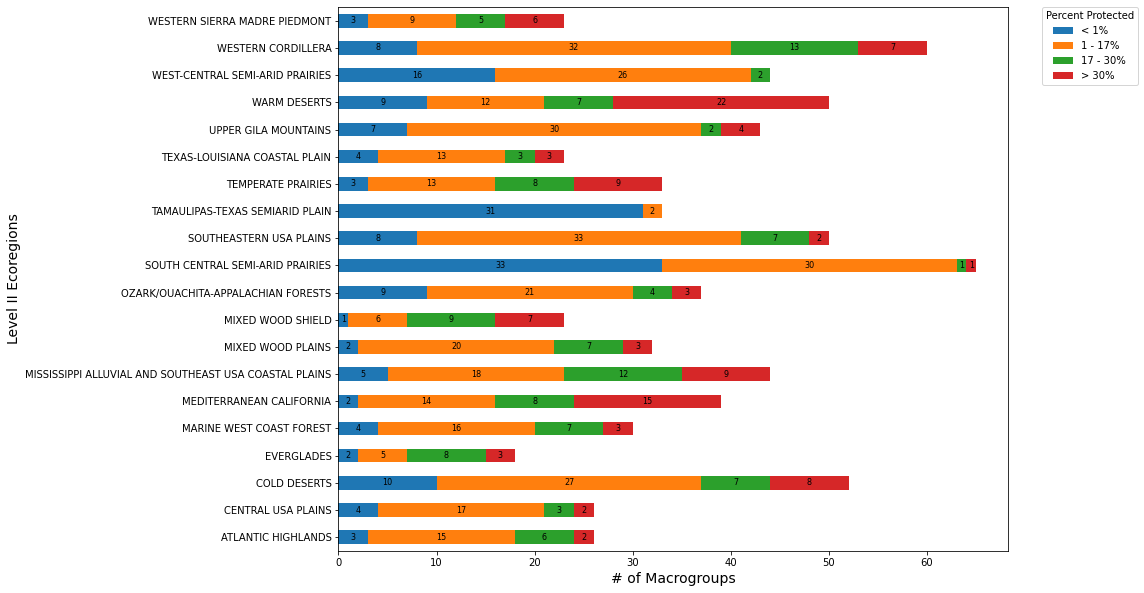

In [52]:
# Plot the unstacked dataframe using horizontal bar plot from Pandas/Matplotlib
ax = dfUnstk.plot.barh(stacked=True, figsize=(12, 10))

# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{width:.0f}'  # f'{width:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

# move the legend
ax.legend(bbox_to_anchor=(1.05, 1), title='Percent Protected', loc='upper left', borderaxespad=0.)

# add labels
ax.set_ylabel("Level II Ecoregions", fontsize=14)
ax.set_xlabel("# of Macrogroups", fontsize=14)

## Citations <a name="citations"></a>
Aycrigg, J. L., Davidson, A., Svancara, L. K., Gergely, K. J., McKerrow, A.J., & Scott, M. (2013). Representation of ecological systems within the protected areas network of the continental United States. PLoSONE, 8(1), e54689. https://doi.org/10.1371/journal.pone.0054689

McKerrow, A. J., A. Davidson, T. S. Earnhardt, A. L. Benson. 2014.  Integrating Recent Land Cover Mapping Efforts to Update the National Gap Analysis Program’s Species Habitat Map.  Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XL-1, 245-252, 2014. 
www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XL-1/245/2014/
doi:10.5194/isprsarchives-XL-1-245-2014

U.S. Geological Survey, Gap Analysis Program. (2016). Protected Areas Database of the United States (PAD-US), version 1.4 Combined Feature Class. https://doi.org/10.5066/F7G73BSZ

U.S. Geological Survey Gap Analysis Program, 20160513, GAP/LANDFIRE National Terrestrial Ecosystems 2011: U.S. Geological Survey, https://doi.org/10.5066/F7ZS2TM0.

USNVC [United States National Vegetation Classification]. 2017. United States National Vegetation Classification Database, V2.01. Federal Geographic Data Committee, Vegetation Subcommittee, Washington DC. [usnvc.org/explore-classification/] (accessed 30 March 2017).